In [1]:
"""
!pip install mss
!pip install matplotlib
!pip install tensorboardX python-dotenv
"""

'\n!pip install mss\n!pip install matplotlib\n!pip install tensorboardX python-dotenv\n'

## preparations

In [2]:
# debug
import time
import random
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [3]:
import os
from dotenv import load_dotenv

EXECUTABLE_NAME = os.getenv('EXECUTABLE_NAME')
GAME_WINDOW_NAME = os.getenv('GAME_WINDOW_NAME')

### camera

In [4]:
from src.gamenv import GameEnv

game_env = GameEnv("snes9x.exe", "mario - Snes9x 1.62.3", (20, 120, -10, -50))
camera = game_env.camera

(80, 80, 3)

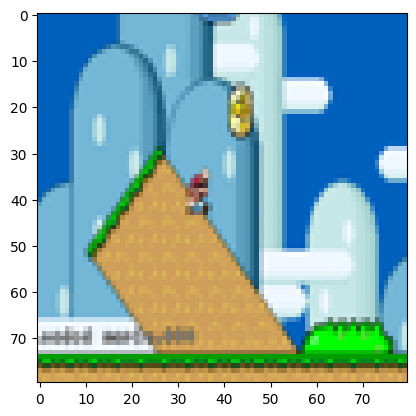

In [5]:
camera.set_foreground_game()
frame = camera.get_frame()
plt.imshow(frame)
frame.shape

### Agent

In [6]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
import gymnasium

# Register the custom environment with Gym
from gymnasium.envs.registration import register

register(
    id='CustomGameEnv-v0',
    entry_point='src.gamenv.gameenv:GameEnv',
    max_episode_steps=200,  # Adjust as needed
)

# Create the environment
env = gymnasium.make('CustomGameEnv-v0')

obs = env.reset()
for _ in range(50):  # Adjust as needed
    action = env.action_space.sample()  # Replace with your RL agent's action
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done or truncated:
        obs = env.reset()
env.close()

c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\envs\registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(
c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\utils\passive_env_checker.py:318: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


In [8]:
import gymnasium
import numpy as np
from gymnasium import spaces

env = gymnasium.make('CustomGameEnv-v0')
n_stack = 30  # Number of frames to stack

class FrameStackingWrapper(gymnasium.Wrapper):
    def __init__(self, env, n_stack=4):
        super(FrameStackingWrapper, self).__init__(env)
        self.n_stack = n_stack
        self.frames = np.zeros((n_stack, *env.observation_space.shape), dtype=np.uint8)
        
        self.observation_space = spaces.Box(low=0, high=255, shape=(n_stack, 80, 80, 3), dtype=np.uint8)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.frames = np.zeros((self.n_stack, *self.env.observation_space.shape), dtype=np.uint8)
        for i in range(self.n_stack):
            self.frames[i] = obs
        return np.array(self.frames), info

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.frames[:-1] = self.frames[1:]  # Shift frames
        self.frames[-1] = obs  # Add new frame
        return np.array(self.frames), reward, done, truncated, info


In [9]:
import torch
import numpy as np
from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.vec_env.vec_frame_stack import VecFrameStack

# Wrap the environment with frame stacking
env = FrameStackingWrapper(env, n_stack=n_stack)
# env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)
# Define the PPO model
model = PPO('MlpPolicy', env, verbose=2,
            learning_rate=1e-3,
            n_steps=1024,
            batch_size=128, 
            clip_range=0.2, 
            max_grad_norm=0.5,
            tensorboard_log="./ppo_super_mario_tensorboard/")

# Train the model
model.learn(total_timesteps=100000)  # You can adjust the number of timesteps

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_super_mario_tensorboard/PPO_27
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 98.9     |
|    ep_rew_mean     | 0.75     |
| time/              |          |
|    fps             | 33       |
|    iterations      | 1        |
|    time_elapsed    | 30       |
|    total_timesteps | 1024     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 111        |
|    ep_rew_mean          | 8.59       |
| time/                   |            |
|    fps                  | 29         |
|    iterations           | 2          |
|    time_elapsed         | 69         |
|    total_timesteps      | 2048       |
| train/                  |            |
|    approx_kl            | 0.01285094 |
|    clip_fraction        | 0.267      |
|    clip_range          

Exception: mario - Snes9x 1.62.3 cannot be minimized.

In [ ]:
model.num_timesteps

10240